In [276]:
module RealRobotWorld

    using Plots
    using Distributions

    include("../scripts/ideal_robot.jl")
    using .RobotWorld: Agent, Landmark, Map, Camera, Robot, World
    using .RobotWorld: data, decision, state_transition, circle_shape, draw, append
    using .RobotWorld: observation_function, visible

    mutable struct RealCamera <: Camera
        map::Map
        distance_range::Array{Float64}
        direction_range::Array{Float64}
        distance_noise_rate::Float64
        direction_noise::Float64
        distance_bias_rate_stddev::Float64
        direction_bias_stddev::Float64
        lastdata

        function RealCamera(
            map;
            distance_range=[0.5, 6.0], # ここからキーワード引数
            direction_range=[-pi/3, pi/3],
            distance_noise_rate=0.1,
            direction_noise=pi/90.0,
            distance_bias_rate_stddev=0.1,
            direction_bias_stddev=pi/90.0,
            lastdata=[])

            new(
                map, 
                distance_range, 
                direction_range, 
                distance_noise_rate,
                direction_noise,
                distance_bias_rate_stddev,
                direction_bias_stddev,
                lastdata
            )
        end
    end

    function noise(self::RealCamera, relpos)
        ell = rand(Normal(relpos[1], relpos[1]*self.distance_noise_rate))
        phi = rand(Normal(relpos[2], self.direction_noise))
        return [ell, phi]
    end

    function bias(self::RealCamera, relpos)
        return relpos + [relpos[1]*self.distance_bias_rate_stddev, self.direction_bias_stddev]
    end

    function RobotWorld.data(self::RealCamera, cam_pose)
        observed = Dict()
        for lm in self.map.landmarks
            observation = observation_function(self, cam_pose, lm.pos)
                
            if visible(self, observation)
                observation = bias(self, observation)                
                observation = noise(self, observation)
                observed[lm.id] = deepcopy(observation)
            end
        end
    
        self.lastdata = deepcopy(observed)
        return observed
    end

    mutable struct RealRobot <: Robot
        pose::Array{Float64}
        color::Symbol
        r::Float64
        agent::Agent
        sensor::RealCamera
        poses::Array{Array{Float64}}
        noise_per_meter::Float64
        noise_std::Float64
        bias_rate_stds::Array{Float64}
        expected_stuck_time::Float64
        expected_escape_time::Float64
        expected_kidnap_time::Float64
        kidnap_range_x::Array{Float64}
        kidnap_range_y::Array{Float64}

        noise_pdf::Exponential{Float64}
        distance_until_noise::Float64
        theta_noise::Normal{Float64}
        bias_rate_nu::Float64
        bias_rate_omega::Float64
        stuck_pdf::Exponential{Float64}
        escape_pdf::Exponential{Float64}
        time_until_stuck::Float64
        time_until_escape::Float64
        is_stuck::Bool
        kidnap_pdf::Exponential{Float64}
        time_until_kidnap::Float64
        kidnap_dist::Array{Uniform{Float64}}

        function RealRobot(
            pose, color, r, agent; 
            sensor=RealCamera(Map()), poses=[pose], # ここからキーワード引数
            noise_per_meter=5, noise_std=pi/60.0, bias_rate_stds=[0.1, 0.1], 
            expected_stuck_time=1e100, expected_escape_time=1e-100,
            expected_kidnap_time=1e100, kidnap_range_x=[-5,5], kidnap_range_y=[-5,5])

            noise_pdf=Exponential(1/(1e-100 + noise_per_meter)) 
            distance_until_noise=rand(noise_pdf)
            theta_noise=Normal(0, noise_std)
            bias_rate_nu = rand(Normal(1.0, bias_rate_stds[1]))
            bias_rate_omega = rand(Normal(1.0, bias_rate_stds[2]))
            stuck_pdf=Exponential(expected_stuck_time)
            escape_pdf=Exponential(expected_escape_time)
            time_until_stuck=rand(stuck_pdf)
            time_until_escape=rand(escape_pdf)
            is_stuck=false    
            kidnap_pdf = Exponential(expected_kidnap_time)
            time_until_kidnap = rand(kidnap_pdf)
            rx, ry = kidnap_range_x, kidnap_range_y
            kidnap_dist = Uniform.([rx[1], ry[1], 0.0], [rx[2]-rx[1], ry[2]-ry[1],2*pi])

            new(
                pose, color, r, agent, sensor, poses, 
                noise_per_meter, noise_std, bias_rate_stds, 
                expected_stuck_time, expected_escape_time,
                expected_kidnap_time, kidnap_range_x, kidnap_range_y,
                noise_pdf, 
                distance_until_noise, theta_noise,
                bias_rate_nu,
                bias_rate_omega,
                stuck_pdf,
                escape_pdf,
                time_until_stuck, time_until_escape, is_stuck,
                kidnap_pdf, time_until_kidnap, kidnap_dist
            )
        end

    end

    function noise(self::RealRobot, pose, nu, omega, time_interval)
    
       self.distance_until_noise = self.distance_until_noise - abs(nu) * time_interval + self.r * abs(omega) * time_interval
        if self.distance_until_noise <= 0.0
            self.distance_until_noise = self.distance_until_noise + rand(self.noise_pdf)
            pose[3] = pose[3] + rand(self.theta_noise)
        end
        return pose
    end

    function bias(self::RealRobot, nu, omega)
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    end

    function stuck(self::RealRobot, nu, omega, time_interval)
        if self.is_stuck
            self.time_until_escape = self.time_until_escape - time_interval
            if self.time_until_escape <= 0.0
                self.time_until_escape = self.time_until_escape = rand(self.escape_pdf)
                self.is_stuck = false
            end
        else
            self.time_until_stuck = self.time_until_stuck - time_interval
            if self.time_until_stuck <= 0.0
                self.time_until_stuck = self.time_until_stuck = rand(self.stuck_pdf)
                self.is_stuck = true
            end        
        end
        return nu*(!self.is_stuck), omega*(!self.is_stuck)
    end

    function kidnap(self::RealRobot, pose, time_interval)
        self.time_until_kidnap = self.time_until_kidnap - time_interval
        if self.time_until_kidnap <= 0.0
            self.time_until_kidnap = self.time_until_kidnap + rand(self.kidnap_pdf)
                
            return rand.(self.kidnap_dist)
        else
            return pose
        end
    end

    function RobotWorld.append(self::World, obj::RealRobot)
        push!(self.objects, deepcopy(obj))
    end

    function RobotWorld.one_step(self::RealRobot, time_interval)
        obs = data(self.sensor, self.pose)
        nu, omega = decision(self.agent, obs)
        nu, omega = bias(self, nu, omega)
        nu, omega = stuck(self, nu, omega, time_interval)
        self.pose = state_transition(nu, omega, time_interval, self.pose)
        self.pose = noise(self, self.pose, nu, omega, time_interval)
        self.pose = kidnap(self, self.pose, time_interval)
    end

end

Main.RealRobotWorld

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
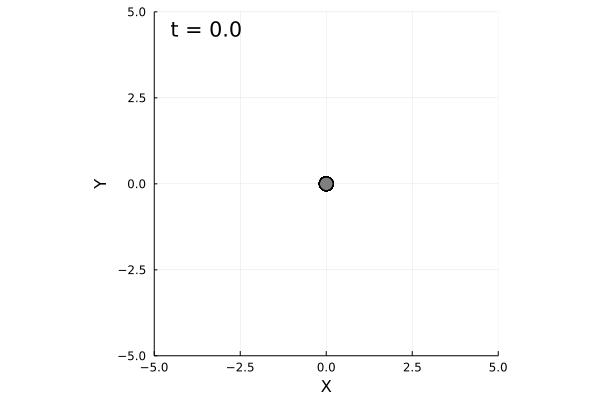

In [226]:
using .RealRobotWorld

world = RealRobotWorld.World(30, 0.1)

for i in 1:100
    circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
    r = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling, bias_rate_stds=[0.0, 0.0])
    
    RealRobotWorld.append(world, r)
end

RealRobotWorld.RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
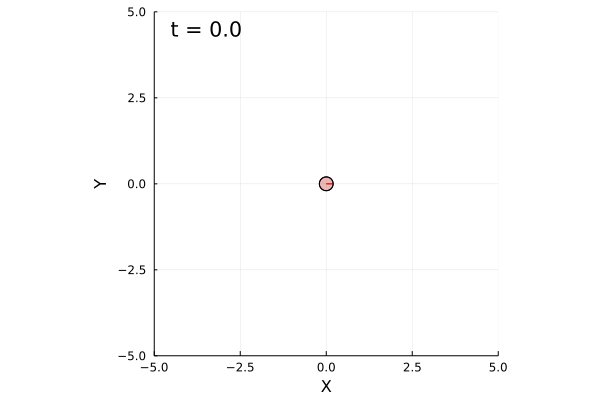

In [241]:
world = RealRobotWorld.World(30, 0.1)

circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
nobias_robot = RealRobotWorld.RobotWorld.IdealRobot([0, 0, 0], :gray, 0.2, circling)    
RealRobotWorld.RobotWorld.append(world, nobias_robot)

biased_robot = RealRobotWorld.RealRobot([0, 0, 0], :red, 0.2, circling, noise_per_meter=0, bias_rate_stds=[0.2, 0.2])
RealRobotWorld.append(world, biased_robot)

RealRobotWorld.RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
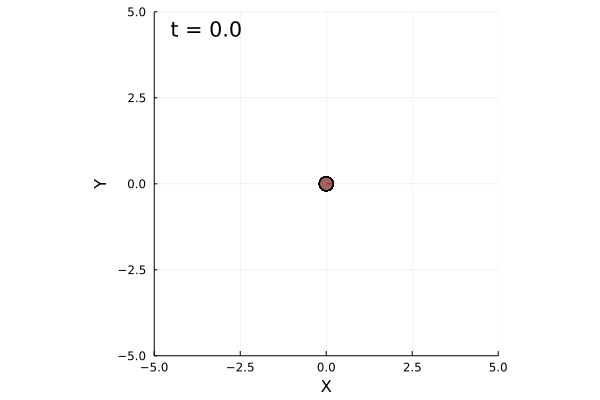

In [229]:
world = RealRobotWorld.World(30, 0.1)

circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
for i in 1:100
    r = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling, 
        noise_per_meter=0, noise_std=0.0, bias_rate_stds=[0.0, 0.0], expected_stuck_time=60, expected_escape_time=60)
    
    RealRobotWorld.append(world, r)
end
r = RealRobotWorld.RobotWorld.IdealRobot([0, 0, 0], :red, 0.2, circling)    
RealRobotWorld.RobotWorld.append(world, r)

RealRobotWorld.RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
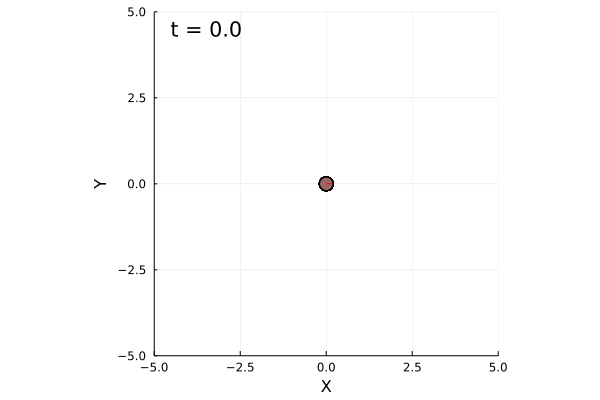

In [230]:
world = RealRobotWorld.World(30, 0.1)

for i in 1:100
    circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
    r = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling,
        noise_per_meter=0, noise_std=0.0, bias_rate_stds=[0.0, 0.0], expected_kidnap_time=5.0)        
    
    RealRobotWorld.append(world, r)
end
r = RealRobotWorld.RobotWorld.IdealRobot([0, 0, 0], :red, 0.2, circling)    
RealRobotWorld.RobotWorld.append(world, r)

RealRobotWorld.RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
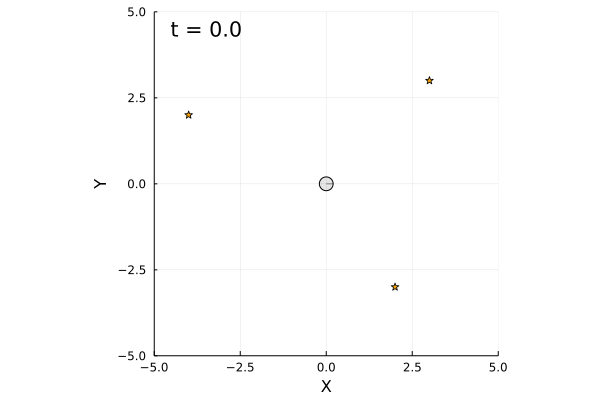

In [277]:
world = RealRobotWorld.World(30, 0.1)

### 地図を生成して３つランドマークを追加 ###
m = RealRobotWorld.Map()
RealRobotWorld.append(m, RealRobotWorld.Landmark([-4, 2]))
RealRobotWorld.append(m, RealRobotWorld.Landmark([2, -3]))
RealRobotWorld.append(m, RealRobotWorld.Landmark([3, 3]))
RealRobotWorld.append(world, m)

### ロボットを作る ###
circling = RealRobotWorld.Agent(0.2, 10.0/180.0*pi)
stationary = RobotWorld.Agent(0.0, 0.0)
r = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling, sensor=RealRobotWorld.RealCamera(m))

RealRobotWorld.append(world, r)

### アニメーション実行 ###
RealRobotWorld.draw(world) # センサ計測結果の描画は１サンプル遅れている